# 1.0 - IMPORTS

## 1.1 - LIBRARIES

In [270]:
import pandas               as pd
import numpy                as np
import matplotlib.pyplot    as plt
import seaborn              as sns
import inflection

from sklearn.cluster        import KMeans

from yellowbrick.cluster import KElbowVisualizer


## 1.2 - LOAD DATA

In [233]:
df_raw = pd.read_csv('../dataset/data.csv', encoding='latin-1')

## 1.3 - HELPER FUNCTIONS

### 1.3.1 - PLOT DIMENSIONS

In [234]:
sns.set(rc = {'figure.figsize':(13,5)})

### 1.3.2 - NA VOLUMETRY

In [235]:
def nan_volumetry(data):
    df_na = pd.DataFrame()
    df_na['attributes'] = data.columns
    df_na['volumetry'] = ''
    df_na['percentual'] = ''

    for i in df_na.index:
        volumetry = data[df_na.loc[i, 'attributes']].isna().sum()
        percentual = (volumetry / data['customer_id'].count()) * 100
        df_na.loc[i, 'volumetry'] = volumetry
        df_na.loc[i, 'percentual'] = f"{percentual:.2f}%"  

    return df_na

# 2.0 - DATA DESCRIPTION

In [236]:
df2 = df_raw.copy()

## 2.1 - DATA DIMENSION

In [237]:
print('Total of unique features:\n')
print(df2.apply(lambda x: x.nunique()))
print('\nNumber of rows: {}'.format(df2.shape[0]))
print('Number of cols: {}'.format(df2.shape[1]))

Total of unique features:

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

Number of rows: 541909
Number of cols: 8


## 2.2 - RENAME COLUMNS

In [238]:
old_columns = df2.columns
snakecase = lambda x: inflection.underscore(x)
new_columns = list(map(snakecase, old_columns))
df2.columns = new_columns

## 2.3 - DATA TYPES

In [239]:
df2.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 2.4 - NAN VOLUMETRY

In [240]:
df2.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [241]:
nan_volumetry(df2)

,attributes,volumetry,percentual
0,invoice_no,0,0.00%
1,stock_code,0,0.00%
2,description,1454,0.36%
3,quantity,0,0.00%
4,invoice_date,0,0.00%
5,unit_price,0,0.00%
6,customer_id,135080,33.20%
7,country,0,0.00%


### 2.4.1 - DROP NA

In [242]:
df2 = df2.dropna(subset=['description', 'customer_id'])
print('Volumetry of removed data: {}%'.format((1-(df2.shape[0])/ df_raw.shape[0])*100))

Volumetry of removed data: 24.9266943342886%


## 2.5 - CHANGE DATA TYPES

In [243]:
df2['invoice_date'] = pd.to_datetime(df2['invoice_date'])
df2['customer_id'] = df2['customer_id'].astype(int)

In [244]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

# 3.0 - DESCRIPTIVE STATISTICS

# 4.0 - FEATURE ENGINEERING

In [245]:
df4 = df2.copy()

In [246]:
df_reference = df4['customer_id'].drop_duplicates(ignore_index = True)

In [247]:
#gross Revenue (quantity * price)
df4['gross_revenue'] = df4['quantity'] * df4['unit_price']
df_monetary = df4[['customer_id','gross_revenue']].groupby('customer_id')['gross_revenue'].sum().reset_index()
df_reference = pd.merge(df_reference, df_monetary, on = 'customer_id', how = 'left')

In [248]:
#recency (Last Day Purchase)
df_recency = df4[['customer_id', 'invoice_date']].groupby('customer_id')['invoice_date'].max().reset_index()
recency_days = (df4['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency['recency_days'] = recency_days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_reference = pd.merge(df_reference, df_recency, on = 'customer_id', how = 'left')

In [249]:
#frequency (Quantity of Purchase)
df_frequency = df4[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id')['invoice_no'].count().reset_index()
df_reference = pd.merge(df_reference, df_frequency, on = 'customer_id', how = 'left')

In [250]:
df_reference

,customer_id,gross_revenue,recency_days,invoice_no
0,17850,5288.63,301,35
1,13047,3079.10,31,18
2,12583,7187.34,2,18
3,13748,948.25,95,5
4,15100,635.10,329,6
...,...,...,...,...
4367,13436,196.89,1,1
4368,15520,343.50,1,1
4369,13298,360.00,0,1
4370,14569,227.39,0,1


# 5.0 - EXPLORATORY DATA ANALYSIS (EDA)

In [251]:
df5 = df_reference.copy()

# 6.0 - HYPERPARAMETER FINE-TUNNING

In [279]:
x = df5.drop(columns = ['customer_id'])

In [280]:
cluster = [2,3,4,5,6]

## 6.1 - WITHIN-CLUSTER SUM OF SQUARE (WSS)

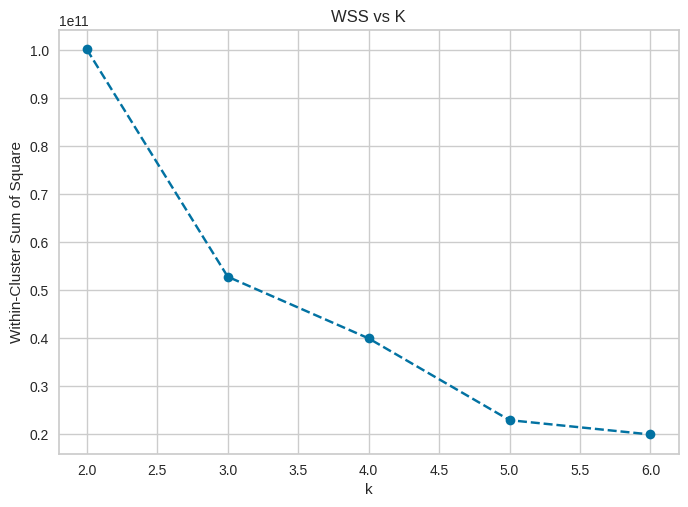

In [282]:
wss = []
for k in cluster:
    #model definition
    kmeans = KMeans(init = 'random',n_clusters = k, n_init = 10, max_iter = 300, random_state = 42)
    #model traning
    kmeans.fit(x)
    #validation
    wss.append(kmeans.inertia_)

#plt SWW - Elbow Method
plt.plot(cluster, wss, linestyle = '--', marker = 'o', color = 'b')
plt.title('WSS vs K')
plt.xlabel('k')
plt.ylabel('Within-Cluster Sum of Square')
plt.show()

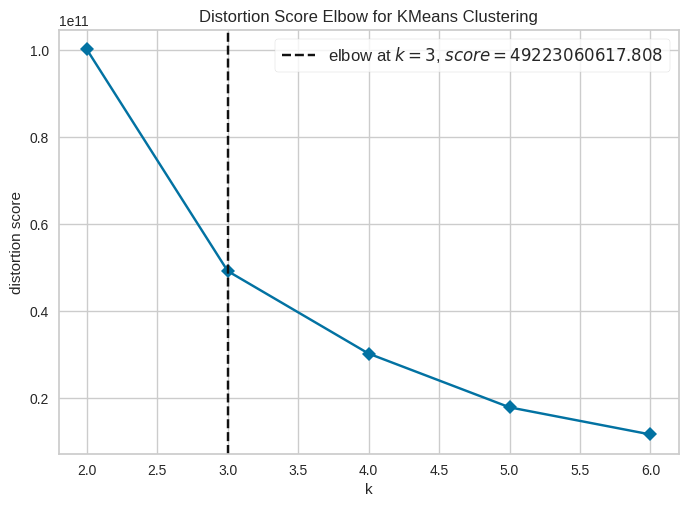

In [283]:
kmeans = KElbowVisualizer(KMeans(), k = cluster, timings = False)
kmeans.fit(x)
kmeans.show();


## 7.2 - SILHOUETT SCORE